# Assembling

This notebook is used to assemble a processable h5ad object for subsequent notebooks.

## Fill in input data, output and settings

In [16]:
####################### TEST NAME ###################################
test = 'Esophagus'
################### DEFINING STRATEGY ###############################
from_h5ad = True #option 1
assembling_10_velocity = False #option 2
assembling_10_public = False #option 3
convert_seurat = False #option 4

###################### INPUT DATA ###################################

#For option 1: The path to an existing .h5ad file
h5ad_files = ['/mnt/workspace/jdetlef/data/anndata/Esophagus.h5ad']
#Manually set existing QC Columns
n_features_by_counts = None
log1p_n_features_by_counts = None
total_counts = None
log1p_total_counts = None
mean_insertsize = None
insertsize_count = None
n_total_fragments = None
n_fragments_in_promoters = None
pct_fragments_in_promoters = None
blacklist_overlaps = None
#total_number_of_fragments
TN = 'TN'
#uniquely_mapped_fragments
UM = 'UM'
#properly_paired_fragments
PP = 'PP'
#uniq_fragments
UQ = 'UQ'
#chrM_fragments
CM = 'CM'

#################### Calc QC Columns ###############################
#set available number of threads
n_threads = 8

#if the mean_insertsize should be calculated specify either a BAM file or a fragments file:
fragments_file = '/mnt/workspace/jdetlef/data/bamfiles/fragments_Esophagus.bed'
bam_file = '/mnt/workspace/jdetlef/data/bamfiles/sorted_Esophagus.bam'

#specify promotors_gtf if another promoter than the fixed ones should be used
#if promotors is None please specify species
#promoters_gtf =  '/mnt/flatfiles/organisms/new_organism/homo_sapiens/104/homo_sapiens.104.promoters2000.gtf'
promoters_gtf = '/mnt/workspace/jdetlef/data/homo_sapiens.104.promoters2000.gtf'
species = None

##################### OUTPUT DATA ###################################
output_dir = '/mnt/workspace/jdetlef/processed_data'

## Import modules

In [17]:
# sctoolbox modules 
import sctoolbox.atac_tree as sub_tree
import sctoolbox.creators as cr
import sctoolbox.fragment_length as fragments
import sctoolbox.atac as atac
import sctoolbox.calc_overlap_pct as overlap
import sctoolbox.analyser 
from sctoolbox.qc_filter import *
from sctoolbox.atac_utils import *
# import episcanpy
import episcanpy as epi

In [18]:
#adata = epi.read_h5ad(h5ad_files[0])

In [19]:
#adata.var

## Setup path handling object 

In [20]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

all directories existing
all directories existing


## Read in data

### Option 1: Read from .h5ad

In [21]:
qc_columns = {}
qc_columns["n_features_by_counts"] = n_features_by_counts
qc_columns["log1p_n_features_by_counts"] = log1p_n_features_by_counts
qc_columns["total_counts"] = total_counts
qc_columns["log1p_total_counts"] = log1p_total_counts
qc_columns["mean_insertsize"] = mean_insertsize
qc_columns['n_total_fragments'] = n_total_fragments
qc_columns['n_fragments_in_promoters'] = n_fragments_in_promoters
qc_columns['pct_fragments_in_promoters'] = pct_fragments_in_promoters
qc_columns["blacklist_overlaps"] = blacklist_overlaps
qc_columns["TN"] = TN
qc_columns["UM"] = UM
qc_columns["PP"] = PP
qc_columns["UQ"] = UQ
qc_columns["CM"] = CM

In [22]:
if from_h5ad:
    
    adata = assemble_from_h5ad(h5ad_files=h5ad_files, from_snapatac=True, qc_columns=qc_columns)

add existing adata.obs columns to infoprocess:

TN:TN
UM:UM
PP:PP
UQ:UQ
CM:CM
setting adata.obs.index = adata.obs[barcode]


## Inspect adata

In [23]:
display(adata)

AnnData object with n_obs × n_vars = 73652 × 174285
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample'
    var: 'peak_chr', 'peak_start', 'peak_end'
    uns: 'infoprocess', 'color_set', 'legend'

In [24]:
adata.var

,peak_chr,peak_start,peak_end
name,,,
b'chr1':10005-10731,chr1,10005,10731
b'chr1':11169-11386,chr1,11169,11386
b'chr1':28730-29439,chr1,28730,29439
b'chr1':29492-29686,chr1,29492,29686
b'chr1':34644-35030,chr1,34644,35030
...,...,...,...
b'chrY':57203298-57203493,chrY,57203298,57203493
b'chrY':57206407-57206560,chrY,57206407,57206560
b'chrY':57215319-57215415,chrY,57215319,57215415


In [25]:
display(adata.var)

,peak_chr,peak_start,peak_end
name,,,
b'chr1':10005-10731,chr1,10005,10731
b'chr1':11169-11386,chr1,11169,11386
b'chr1':28730-29439,chr1,28730,29439
b'chr1':29492-29686,chr1,29492,29686
b'chr1':34644-35030,chr1,34644,35030
...,...,...,...
b'chrY':57203298-57203493,chrY,57203298,57203493
b'chrY':57206407-57206560,chrY,57206407,57206560
b'chrY':57215319-57215415,chrY,57215319,57215415


In [26]:
display(adata.obs)

,TN,UM,PP,UQ,CM,file,sample
barcode,,,,,,,
AAACTACCAGAAACCCGAGATA,33.0,18.0,18.0,15.0,0.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1
AAACTACCAGAAACCTAAGTGG,52.0,36.0,35.0,32.0,1.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1
AAACTACCAGAAACGGATCAGT,27.0,19.0,19.0,19.0,0.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1
AAACTACCAGAAACGTCCCGTT,6223.0,5232.0,5214.0,3780.0,18.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1
AAACTACCAGAAACTAGCCCTA,41.0,29.0,29.0,26.0,0.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1
...,...,...,...,...,...,...,...
TTCCATCCTCTTTCGCGTGTAA,9.0,6.0,6.0,6.0,0.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1
TTCCATCCTCTTTCTGCAGACT,10.0,6.0,6.0,6.0,1.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1
TTCCATCCTCTTTCTGGCGCAG,17.0,5.0,5.0,5.0,1.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1


## Calculate missing columns

### 1. calculate scanpy qc_metrics (n_features)

In [27]:
if qc_columns['n_features_by_counts'] is None or qc_columns['log1p_n_features_by_counts'] is None:
    adata = analyser.calculate_qc_metrics(adata, var_type='features')
    
    qc_columns['n_features_by_counts'] = 'n_features_by_counts'
    qc_columns['log1p_n_features_by_counts'] = 'log1p_n_features_by_counts'
    qc_columns['total_counts'] = 'total_counts'
    qc_columns['log1p_total_counts'] = 'log1p_total_counts'
    
    build_legend(adata, 'n_features_by_counts', 'n_features_by_counts')
    build_legend(adata, 'log1p_n_features_by_counts', 'log1p_n_features_by_counts')
    build_legend(adata, 'total_counts', 'total_counts')
    build_legend(adata, 'log1p_total_counts', 'log1p_total_counts')

adata.obs

,TN,UM,PP,UQ,CM,file,sample,n_features_by_counts,log1p_n_features_by_counts,total_counts,log1p_total_counts
barcode,,,,,,,,,,,
AAACTACCAGAAACCCGAGATA,33.0,18.0,18.0,15.0,0.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1,5,1.791759,5.0,1.791759
AAACTACCAGAAACCTAAGTGG,52.0,36.0,35.0,32.0,1.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1,17,2.890372,17.0,2.890372
AAACTACCAGAAACGGATCAGT,27.0,19.0,19.0,19.0,0.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1,10,2.397895,10.0,2.397895
AAACTACCAGAAACGTCCCGTT,6223.0,5232.0,5214.0,3780.0,18.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1,1648,7.407924,1791.0,7.491087
AAACTACCAGAAACTAGCCCTA,41.0,29.0,29.0,26.0,0.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1,13,2.639057,13.0,2.639057
...,...,...,...,...,...,...,...,...,...,...,...
TTCCATCCTCTTTCGCGTGTAA,9.0,6.0,6.0,6.0,0.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1,3,1.386294,3.0,1.386294
TTCCATCCTCTTTCTGCAGACT,10.0,6.0,6.0,6.0,1.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1,3,1.386294,3.0,1.386294
TTCCATCCTCTTTCTGGCGCAG,17.0,5.0,5.0,5.0,1.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1,0,0.000000,0.0,0.000000


### 2. calc mean insertsize and count if missing 

In [28]:
if qc_columns['mean_insertsize'] is None or qc_columns['insertsize_count'] is None:
    atac.add_insertsize(adata, fragments=fragments_file) # fragments=fragments_file or use bam=bam_file instead of fragments
    
    # update column dictionary
    qc_columns['mean_insertsize'] = 'mean_insertsize'
    qc_columns['insertsize_count'] = 'insertsize_count'
    
    # update infoprocess table
    build_legend(adata, 'mean_insertsize', 'mean_insertsize')
    build_legend(adata, 'insertsize_count', 'insertsize_count')
    
adata.obs

Counting fragment lengths from fragments file...
Done reading file - elapsed time: 0:03:16
Converting counts to dataframe...
Done getting insertsizes from fragments!
Added insertsize information to adata.obs[["insertsize_count", "mean_insertsize"]] and adata.uns["insertsize_distribution"].


,TN,UM,PP,UQ,CM,file,sample,n_features_by_counts,log1p_n_features_by_counts,total_counts,log1p_total_counts,insertsize_count,mean_insertsize
barcode,,,,,,,,,,,,,
AAACTACCAGAAACCCGAGATA,33.0,18.0,18.0,15.0,0.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1,5,1.791759,5.0,1.791759,12.0,85.18
AAACTACCAGAAACCTAAGTGG,52.0,36.0,35.0,32.0,1.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1,17,2.890372,17.0,2.890372,30.0,158.53
AAACTACCAGAAACGGATCAGT,27.0,19.0,19.0,19.0,0.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1,10,2.397895,10.0,2.397895,16.0,162.50
AAACTACCAGAAACGTCCCGTT,6223.0,5232.0,5214.0,3780.0,18.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1,1648,7.407924,1791.0,7.491087,4923.0,137.92
AAACTACCAGAAACTAGCCCTA,41.0,29.0,29.0,26.0,0.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1,13,2.639057,13.0,2.639057,26.0,126.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCCATCCTCTTTCGCGTGTAA,9.0,6.0,6.0,6.0,0.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1,3,1.386294,3.0,1.386294,6.0,117.17
TTCCATCCTCTTTCTGCAGACT,10.0,6.0,6.0,6.0,1.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1,3,1.386294,3.0,1.386294,2.0,92.50
TTCCATCCTCTTTCTGGCGCAG,17.0,5.0,5.0,5.0,1.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1,0,0.000000,0.0,0.000000,3.0,77.00


<AxesSubplot: xlabel='Insertsize (bp)', ylabel='Count'>

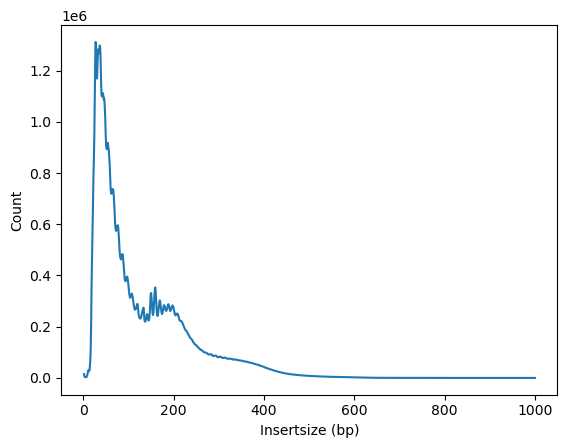

In [29]:
atac.plot_insertsize(adata, barcodes=None)

### 3. promotor enrichment 

In [30]:
if qc_columns['n_fragments_in_promoters'] is None:
    overlap.pct_fragments_in_promoters(adata, gtf_file=promoters_gtf, species=species, bam_file=bam_file, cb_col=None, nproc=1)
    
    # n_total_fragments, n_fragments_in_promoters, pct_fragments_in_promoters
    # update column dictionary
    qc_columns['n_total_fragments'] = 'n_total_fragments'
    qc_columns['n_fragments_in_promoters'] = 'n_fragments_in_promoters'
    qc_columns['pct_fragments_in_promoters'] = 'pct_fragments_in_promoters'
    # update infoprocess table
    build_legend(adata, 'n_total_fragments', 'n_total_fragments')
    build_legend(adata, 'n_fragments_in_promoters', 'n_fragments_in_promoters')
    build_legend(adata, 'pct_fragments_in_promoters', 'pct_fragments_in_promoters')
    

Converting GTF to BED...
Converting BAM to fragments file! This may take a while...
Finished creating fragments file. Now sorting...
Finished sorting fragments
Finding overlaps...


NameError: name 'sys' is not defined

## Inspect adata.obs

In [ ]:
adata.obs

## Save adata to .h5ad

In [ ]:
adata_output = tree.assembled_anndata
adata_output

In [ ]:
#Saving the data
cr.build_infor(adata, "Test_number", test)
cr.build_infor(adata, "Anndata_path", output_dir)

adata_output = tree.assembled_anndata
adata.write(filename=adata_output)